# Multi-layer Perceptron Voting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load Split Data

In [ ]:
clean_train = "clean_train.csv"
clean_val = "clean_val.csv"
clean_test = "clean_test.csv"

rand_mlp = 44
num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [ ]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

In [ ]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

In [ ]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)



## Feature Scaling

In [ ]:
scaler = MinMaxScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.fit_transform(X_val[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

X_train.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA
553238,10,30,1,20,34,8,0.021090,0.000200,0,0,0,0,1,0,0.002928,0.004387,0.002193,0.484536
312927,24,27,0,7,37,3,0.115993,0.000100,0,1,1,0,0,1,0.005532,0.012612,0.010783,0.845361
598084,37,40,0,20,31,2,0.421793,0.005601,1,0,0,0,0,0,0.039961,0.091208,0.068446,0.742268


## Model Training

In [ ]:
reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    min_lr=1e-5)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True)

### Model 1

In [ ]:
cols_m1 = list(X_train.columns)

In [ ]:
model_1 = keras.Sequential()

model_1.add(layers.Dense(64, input_shape=[len(cols_m1)], activation="relu"))
model_1.add(layers.Dense(512, activation="relu"))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(loss="binary_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 35009 (136.75 KB)
Trainable params: 35009 (136.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_1.fit(X_train,
                      y_train,
                      epochs=100,
                      batch_size=1000,
                      verbose=1,
                      validation_data=(X_val, y_val),
                      callbacks=[reduce_learning_rate, early_stopping])

Epoch 1/100
627/627 [==============================] - 6s 8ms/step - loss: 0.4624 - accuracy: 0.8146 - val_loss: 0.3819 - val_accuracy: 0.8323 - lr: 0.0010
Epoch 2/100
627/627 [==============================] - 5s 7ms/step - loss: 0.3716 - accuracy: 0.8391 - val_loss: 0.3469 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 3/100
627/627 [==============================] - 5s 8ms/step - loss: 0.3406 - accuracy: 0.8595 - val_loss: 0.3307 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 4/100
627/627 [==============================] - 5s 7ms/step - loss: 0.3219 - accuracy: 0.8708 - val_loss: 0.3137 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 5/100
627/627 [==============================] - 5s 7ms/step - loss: 0.3128 - accuracy: 0.8751 - val_loss: 0.3050 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 6/100
627/627 [==============================] - 5s 7ms/step - loss: 0.3071 - accuracy: 0.8779 - val_loss: 0.2999 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 7/100
627/627 [==============================] - 5s 7ms/st

In [ ]:
results = model_1.evaluate(X_test, y_test)

print("Accuracy:", round(results[1], 4))

4204/4204 [==============================] - 6s 1ms/step - loss: 0.2798 - accuracy: 0.9011
Accuracy: 0.9011


In [ ]:
df_history = pd.DataFrame(history.history)
df_history["epoch"] = history.epoch

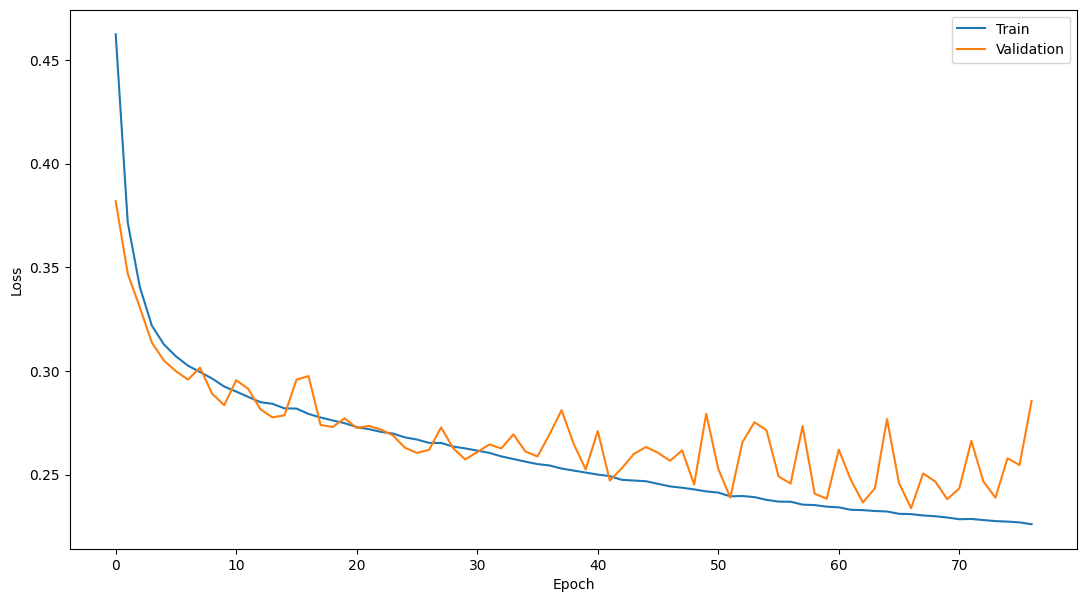

In [ ]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df_history["epoch"], df_history["loss"], label="Train")
plt.plot(df_history["epoch"], df_history["val_loss"], label = "Validation")
plt.legend()
plt.show()

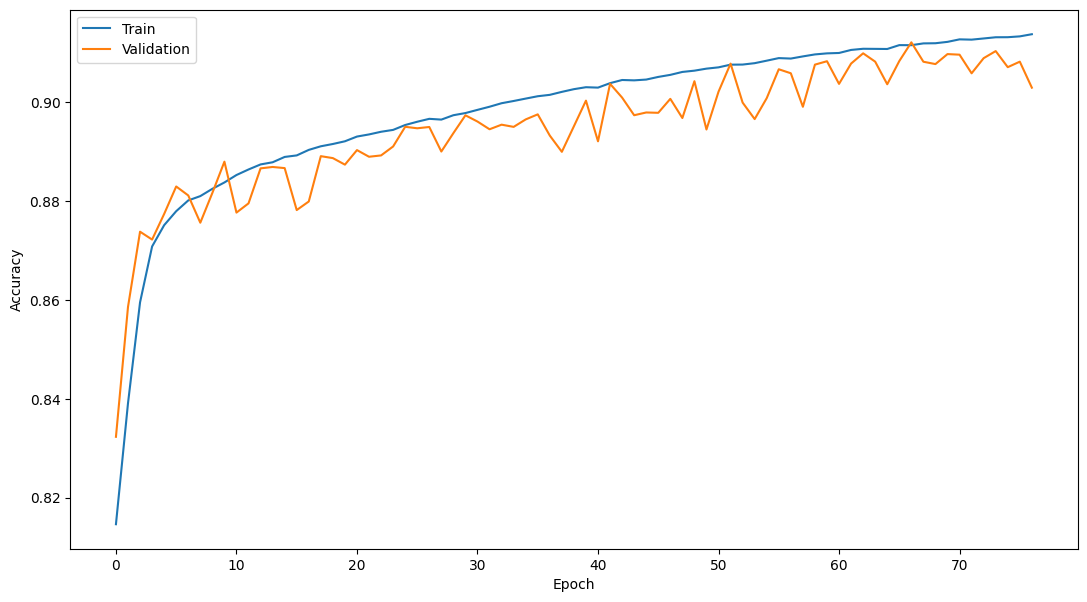

In [ ]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(df_history["epoch"], df_history["accuracy"], label="Train")
plt.plot(df_history["epoch"], df_history["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

In [ ]:
y_pred1 = model_1.predict(X_test)
y_pred1 = y_pred1.flatten().tolist()

y_m1 = np.round(y_pred1).astype(int)

4204/4204 [==============================] - 6s 1ms/step


In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_m1)))
print("Precisión:    %.4f" % (precision_score(y_test, y_m1, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_m1, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_m1, average="macro")))

Exactitud:    0.9011
Precisión:    0.8699
Sensibilidad: 0.7664
F1-score:     0.8044


### Model 2

In [ ]:
cols_m2 = ["State","BankState","DifState","Sector","AppYear","Term","GrDisburs","ApprovSBA","SecuredSBA"]

In [ ]:
model_2 = keras.Sequential()

model_2.add(layers.Dense(128, input_shape=[len(cols_m2)], activation="relu"))
model_2.add(layers.Dense(640, activation="relu"))
model_2.add(layers.Dropout(0.4))
model_2.add(layers.Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.Nadam(learning_rate=0.001)

model_2.compile(loss="binary_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1280      
                                                                 
 dense_7 (Dense)             (None, 640)               82560     
                                                                 
 dropout_2 (Dropout)         (None, 640)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 641       
                                                                 
Total params: 84481 (330.00 KB)
Trainable params: 84481 (330.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model_2.fit(X_train[cols_m2],
                      y_train,
                      epochs=200,
                      batch_size=500,
                      verbose=1,
                      validation_data=(X_val[cols_m2], y_val),
                      callbacks=[reduce_learning_rate, early_stopping])

Epoch 1/200
1254/1254 [==============================] - 11s 8ms/step - loss: 0.3937 - accuracy: 0.8352 - val_loss: 0.3342 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 2/200
1254/1254 [==============================] - 9s 7ms/step - loss: 0.3299 - accuracy: 0.8665 - val_loss: 0.3187 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 3/200
1254/1254 [==============================] - 9s 7ms/step - loss: 0.3184 - accuracy: 0.8719 - val_loss: 0.3132 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 4/200
1254/1254 [==============================] - 9s 7ms/step - loss: 0.3124 - accuracy: 0.8746 - val_loss: 0.3028 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 5/200
1254/1254 [==============================] - 9s 7ms/step - loss: 0.3082 - accuracy: 0.8769 - val_loss: 0.2981 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 6/200
1254/1254 [==============================] - 9s 7ms/step - loss: 0.3041 - accuracy: 0.8785 - val_loss: 0.2952 - val_accuracy: 0.8840 - lr: 0.0010
Epoch 7/200
1254/1254 [============================

In [ ]:
results = model_2.evaluate(X_test[cols_m2], y_test)

print("Accuracy:", round(results[1], 4))

4204/4204 [==============================] - 6s 2ms/step - loss: 0.3039 - accuracy: 0.8936
Accuracy: 0.8936


In [ ]:
df_history = pd.DataFrame(history.history)
df_history["epoch"] = history.epoch

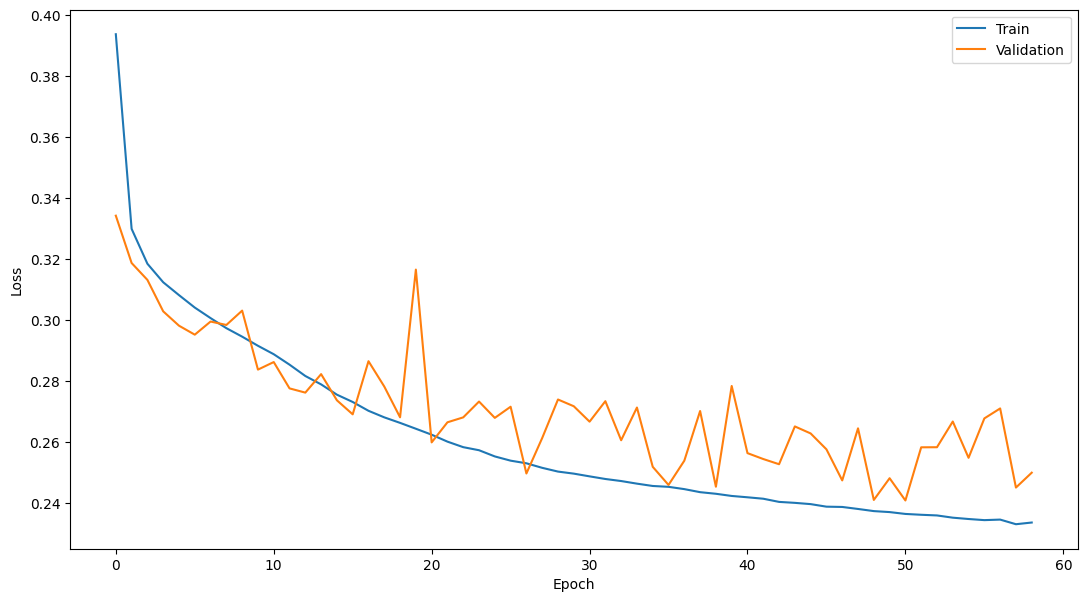

In [ ]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df_history["epoch"], df_history["loss"], label="Train")
plt.plot(df_history["epoch"], df_history["val_loss"], label = "Validation")
plt.legend()
plt.show()

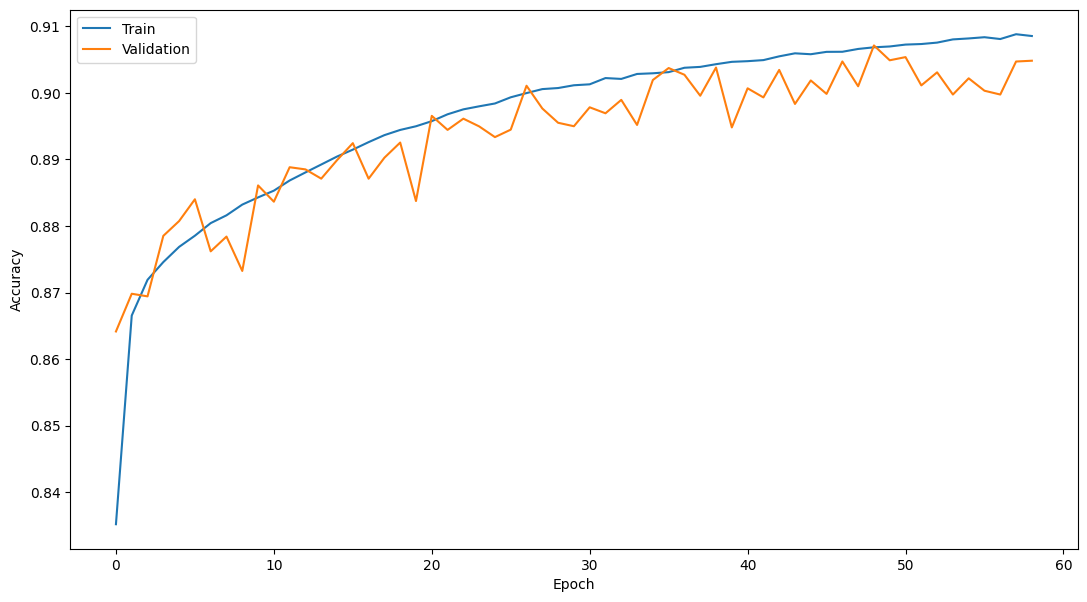

In [ ]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(df_history["epoch"], df_history["accuracy"], label="Train")
plt.plot(df_history["epoch"], df_history["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

In [ ]:
y_pred2 = model_2.predict(X_test[cols_m2])
y_pred2 = y_pred2.flatten().tolist()

y_m2 = np.round(y_pred2).astype(int)

4204/4204 [==============================] - 6s 1ms/step


In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_m2)))
print("Precisión:    %.4f" % (precision_score(y_test, y_m2, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_m2, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_m2, average="macro")))

Exactitud:    0.8936
Precisión:    0.8658
Sensibilidad: 0.7404
F1-score:     0.7822


### Model 3

In [ ]:
cols_m3 = list(X_train.columns) # ["State","BankState","DifState","Sector","AppYear","Term","GrDisburs","ApprovSBA","SecuredSBA"]

In [ ]:
model_3 = keras.Sequential()

model_3.add(layers.Dense(32, input_shape=[len(cols_m3)], activation="relu"))
model_3.add(layers.Dense(64, activation="relu"))
model_3.add(layers.Dense(512, activation="relu"))
model_3.add(layers.Dropout(0.4))
model_3.add(layers.Dense(64, activation="relu"))
model_3.add(layers.Dropout(0.3))
model_3.add(layers.Dense(16, activation="relu"))
model_3.add(layers.Dense(1, activation="sigmoid"))

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_3.compile(loss="binary_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 32)                608       
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dense_15 (Dense)            (None, 512)               33280     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                32832     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 16)               

In [ ]:
history = model_3.fit(X_train[cols_m3],
                      y_train,
                      epochs=200,
                      batch_size=2000,
                      verbose=1,
                      validation_data=(X_val[cols_m3], y_val),
                      callbacks=[reduce_learning_rate, early_stopping])

Epoch 1/200
314/314 [==============================] - 6s 16ms/step - loss: 0.4328 - accuracy: 0.8247 - val_loss: 0.3940 - val_accuracy: 0.8256 - lr: 0.0010
Epoch 2/200
314/314 [==============================] - 5s 15ms/step - loss: 0.3879 - accuracy: 0.8294 - val_loss: 0.3818 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 3/200
314/314 [==============================] - 5s 15ms/step - loss: 0.3585 - accuracy: 0.8478 - val_loss: 0.3258 - val_accuracy: 0.8692 - lr: 0.0010
Epoch 4/200
314/314 [==============================] - 5s 15ms/step - loss: 0.3306 - accuracy: 0.8659 - val_loss: 0.3141 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 5/200
314/314 [==============================] - 5s 15ms/step - loss: 0.3149 - accuracy: 0.8728 - val_loss: 0.3007 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 6/200
314/314 [==============================] - 5s 15ms/step - loss: 0.3050 - accuracy: 0.8772 - val_loss: 0.2940 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 7/200
314/314 [==============================] - 5s 

In [ ]:
results = model_3.evaluate(X_test[cols_m3], y_test)

print("Accuracy:", round(results[1], 4))

4204/4204 [==============================] - 6s 2ms/step - loss: 0.2947 - accuracy: 0.8956
Accuracy: 0.8956


In [ ]:
df_history = pd.DataFrame(history.history)
df_history["epoch"] = history.epoch

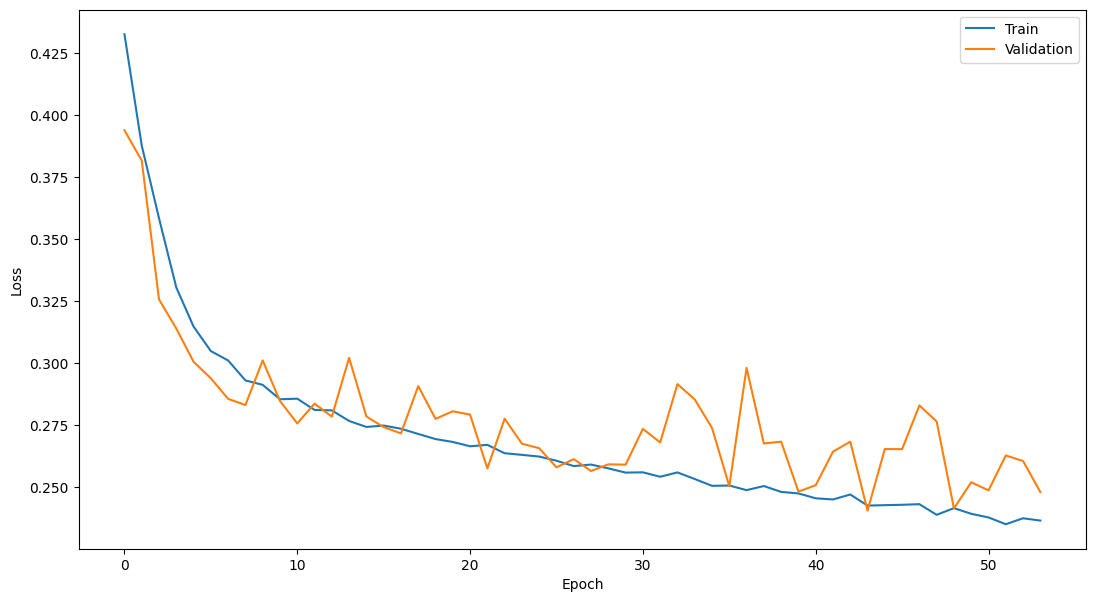

In [ ]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df_history["epoch"], df_history["loss"], label="Train")
plt.plot(df_history["epoch"], df_history["val_loss"], label = "Validation")
plt.legend()
plt.show()

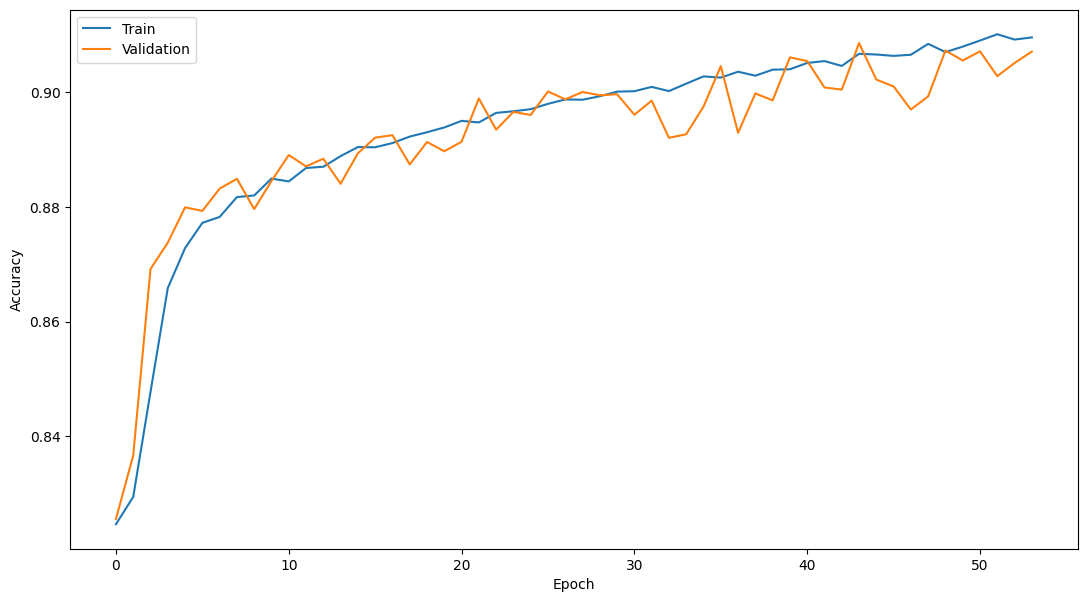

In [ ]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(df_history["epoch"], df_history["accuracy"], label="Train")
plt.plot(df_history["epoch"], df_history["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

In [ ]:
y_pred3 = model_3.predict(X_test[cols_m3])
y_pred3 = y_pred3.flatten().tolist()

y_m3 = np.round(y_pred3).astype(int)

4204/4204 [==============================] - 6s 1ms/step


In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_m3)))
print("Precisión:    %.4f" % (precision_score(y_test, y_m3, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_m3, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_m3, average="macro")))

Exactitud:    0.8956
Precisión:    0.8689
Sensibilidad: 0.7455
F1-score:     0.7873


## MLP Voting

### Majority Voting

In [ ]:
y_vote = np.array([1 if sum(votes) >= 1.5 else 0 for votes in zip(y_pred1, y_pred2, y_pred3)])

In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_vote)))
print("Precisión:    %.4f" % (precision_score(y_test, y_vote, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_vote, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_vote, average="macro")))

Exactitud:    0.8995
Precisión:    0.8774
Sensibilidad: 0.7535
F1-score:     0.7959


In [ ]:
y_vote = np.array([1 if sum(votes) >= 2 else 0 for votes in zip(y_m1, y_m2, y_m3)])

In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_vote)))
print("Precisión:    %.4f" % (precision_score(y_test, y_vote, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_vote, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_vote, average="macro")))

Exactitud:    0.8995
Precisión:    0.8760
Sensibilidad: 0.7548
F1-score:     0.7966


### Weighted Voting

In [ ]:
weights = [0.4, 0.3, 0.3]

In [ ]:
y_vote = np.array([1 if sum(w * v for w, v in zip(weights, votes)) >= 0.5 else 0 for votes in zip(y_pred1, y_pred2, y_pred3)])

In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_vote)))
print("Precisión:    %.4f" % (precision_score(y_test, y_vote, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_vote, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_vote, average="macro")))

Exactitud:    0.8998
Precisión:    0.8770
Sensibilidad: 0.7549
F1-score:     0.7970


In [ ]:
y_vote = np.array([1 if sum(w * v for w, v in zip(weights, votes)) >= 0.5 else 0 for votes in zip(y_m1, y_m2, y_m3)])

In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_vote)))
print("Precisión:    %.4f" % (precision_score(y_test, y_vote, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_vote, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_vote, average="macro")))

Exactitud:    0.8995
Precisión:    0.8760
Sensibilidad: 0.7548
F1-score:     0.7966


### Classification Report

In [ ]:
weights = [0.4, 0.3, 0.3]

In [ ]:
y_vote = np.array([1 if sum(w * v for w, v in zip(weights, votes)) >= 0.5 else 0 for votes in zip(y_pred1, y_pred2, y_pred3)])

In [ ]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_vote)))
print("Precisión:    %.4f" % (precision_score(y_test, y_vote, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_vote, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_vote, average="macro")))

Exactitud:    0.8998
Precisión:    0.8770
Sensibilidad: 0.7549
F1-score:     0.7970


In [ ]:
print(classification_report(y_test, y_vote, digits=4))

              precision    recall  f1-score   support

           0     0.9063    0.9794    0.9414    110629
           1     0.8477    0.5304    0.6525     23869

    accuracy                         0.8998    134498
   macro avg     0.8770    0.7549    0.7970    134498
weighted avg     0.8959    0.8998    0.8902    134498



### Confusion Matrix

In [ ]:
cm_mlp = confusion_matrix(y_test, y_vote, normalize="all")
print(cm_mlp)

[[0.80562536 0.01690731]
 [0.08333953 0.09412779]]


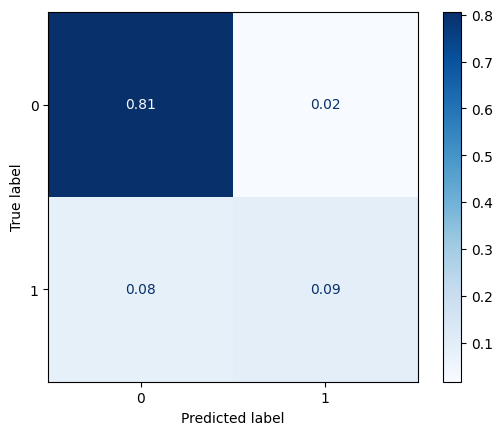

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp.plot(cmap="Blues", values_format=".2f")

### ROC Curve & AUC

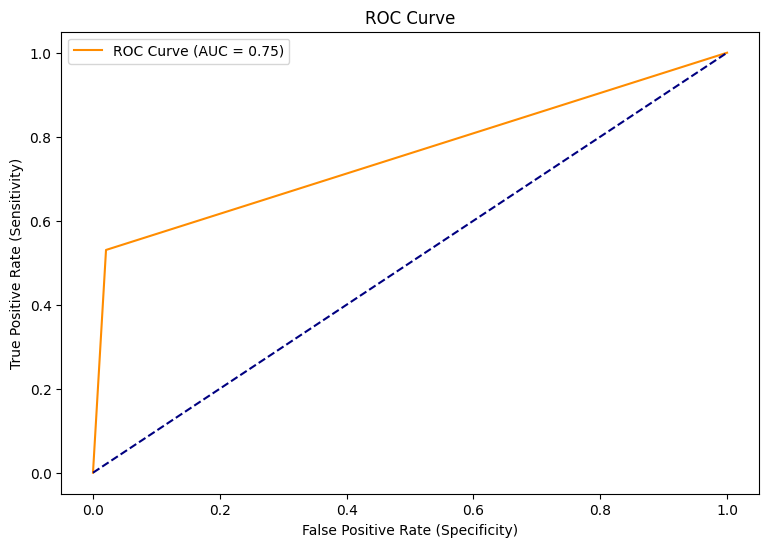

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_vote)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()